[Article Link](https://www.kaggle.com/youssefhesham8/chrun-bank-data-with-simple-ann)

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
df = pd.read_csv(r'C:\Data Sciences\Data\all_data_files\Churn_Modelling.csv')
print('\nDateframe Shape: ', {df.shape})
df.head()


Dateframe Shape:  {(10000, 14)}


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [9]:
for i in df.columns:
    if i != 'CreditScore':
       print(f"{i} -> {df[i].unique()}")

Geography -> ['France' 'Spain' 'Germany']
Gender -> ['Female' 'Male']
Age -> [42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49
 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53
 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure -> [ 2  1  8  7  4  6  3 10  5  9  0]
Balance -> [     0.    83807.86 159660.8  ...  57369.61  75075.31 130142.79]
NumOfProducts -> [1 3 2 4]
HasCrCard -> [1 0]
IsActiveMember -> [1 0]
EstimatedSalary -> [101348.88 112542.58 113931.57 ...  42085.58  92888.52  38190.78]
Exited -> [1 0]


In [10]:
df['Gender'] = df['Gender'].replace({'Male':1 , 'Female':0})
df = pd.get_dummies(data = df, columns=['Geography'])
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0


In [11]:
df[['Balance','EstimatedSalary']].describe()

,Balance,EstimatedSalary
count,10000.000000,10000.000000
mean,76485.889288,100090.239881
std,62397.405202,57510.492818
min,0.000000,11.580000
25%,0.000000,51002.110000
50%,97198.540000,100193.915000
75%,127644.240000,149388.247500
max,250898.090000,199992.480000


<AxesSubplot:xlabel='Balance'>

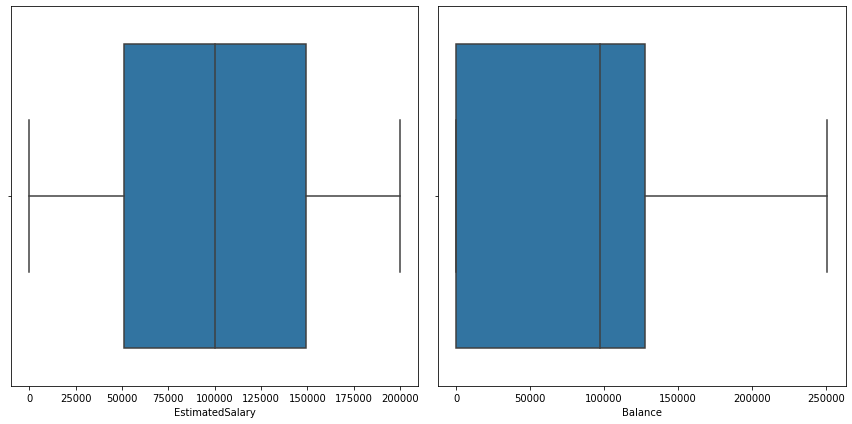

In [12]:
plt.rcParams["figure.figsize"] = [12,6] 
plt.rcParams["figure.autolayout"] = True 

fig, axes = plt.subplots(1, 2)
sns.boxplot(x = df['EstimatedSalary'], ax = axes[0],  showfliers = True)  
sns.boxplot(x = df['Balance'] , ax = axes[1], showfliers = True )

In [13]:
scale = Normalizer()
lis = ['Age','CreditScore' , 'Balance', 'EstimatedSalary']
df[lis] = scale.fit_transform(df[lis])
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.006108,0,0.000414,2,0.000000,1,1,1,0.999981,1,1,0,0
1,0.004333,0,0.000292,1,0.597258,1,0,1,0.802037,0,0,0,1
2,0.002559,0,0.000214,8,0.814000,3,1,0,0.580859,1,1,0,0


In [15]:
from imblearn.over_sampling import SMOTE

sam = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote, y_smote = sam.fit_resample(X,Y)

x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote,test_size= 0.2, stratify= y_smote)

In [17]:
def model(x_train, x_test, y_train, y_test):
    mod = keras.Sequential([
        keras.layers.Dense(1500, input_dim = len(x_train.columns), activation = 'relu'),
        keras.layers.Dense(700, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid'),
    ])
    
    mod.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics = ['accuracy']
    )
    
    mod.fit(x_train, y_train, epochs=10)
    
    print(f'\n test accuracy -> {mod.evaluate(x_test, y_test)}')

    y_pred = mod.predict(x_test)
    y_pred = np.round(y_pred)
    
    return y_pred

y_pred = model(x_train, x_test, y_train,y_test)

Epoch 1/10
399/399 [==============================] - 6s 13ms/step - loss: 0.6041 - accuracy: 0.6684
Epoch 2/10
399/399 [==============================] - 4s 10ms/step - loss: 0.5334 - accuracy: 0.7271
Epoch 3/10
399/399 [==============================] - 4s 9ms/step - loss: 0.5214 - accuracy: 0.7356
Epoch 4/10
399/399 [==============================] - 4s 9ms/step - loss: 0.5144 - accuracy: 0.7422
Epoch 5/10
399/399 [==============================] - 4s 9ms/step - loss: 0.5086 - accuracy: 0.7456
Epoch 6/10
399/399 [==============================] - 4s 9ms/step - loss: 0.5057 - accuracy: 0.7459
Epoch 7/10
399/399 [==============================] - 3s 8ms/step - loss: 0.5038 - accuracy: 0.7483
Epoch 8/10
399/399 [==============================] - 3s 8ms/step - loss: 0.5007 - accuracy: 0.7482
Epoch 9/10
399/399 [==============================] - 3s 8ms/step - loss: 0.4974 - accuracy: 0.7512
Epoch 10/10
100/100 [==============================] - 1s 6ms/step - loss: 0.5087 - accuracy: 0.74

report               precision    recall  f1-score   support

           0       0.79      0.68      0.73      1593
           1       0.72      0.82      0.77      1593

    accuracy                           0.75      3186
   macro avg       0.75      0.75      0.75      3186
weighted avg       0.75      0.75      0.75      3186



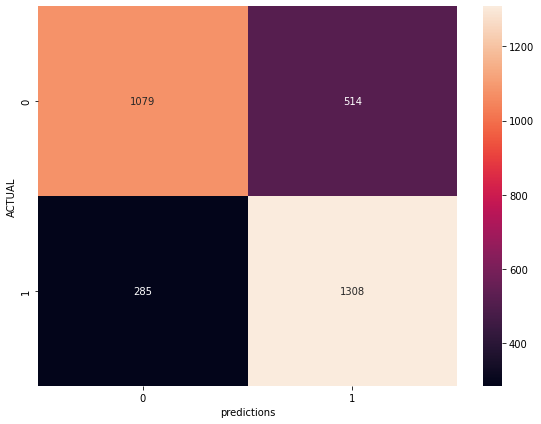

In [18]:
con = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
print(f'report {classification_report(y_test, y_pred)}')

plt.figure(figsize=(8,6))
sns.heatmap(con, annot = True, fmt = "d")
plt.xlabel("predictions")
plt.ylabel("ACTUAL")
plt.show()

In [19]:
import matplotlib.pyplot as plt
import shap

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 6)                 66        
                                                                 
 drop1 (Dropout)             (None, 6)                 0         
                                                                 
 h2 (Dense)                  (None, 3)                 21        
                                                                 
 drop2 (Dropout)             (None, 3)                 0         
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


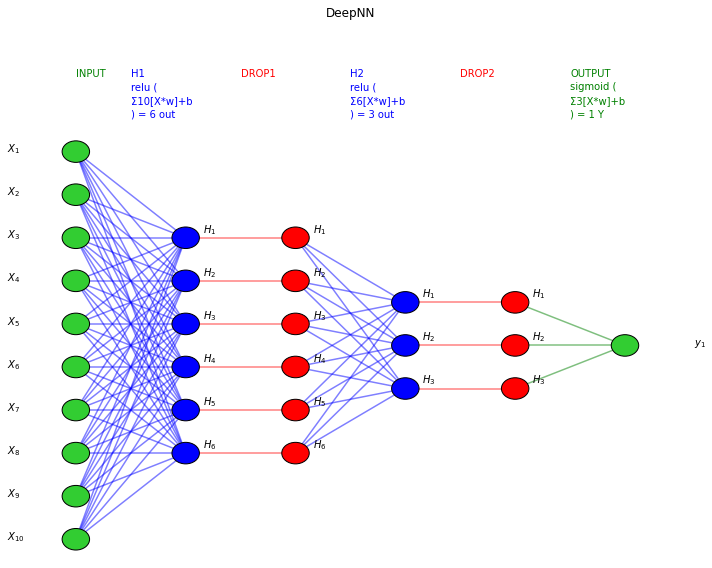

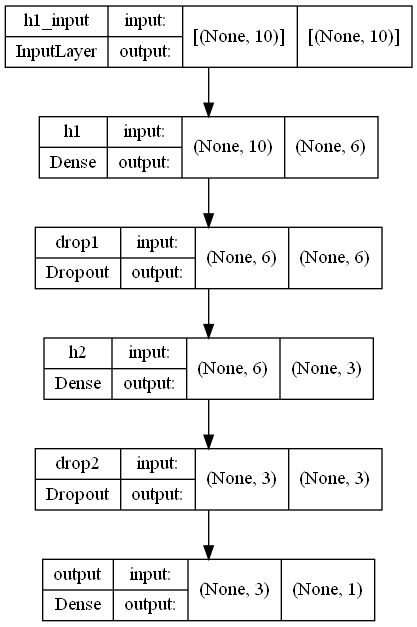

In [27]:
from tensorflow.keras import models, layers, utils, backend as K

n_features = 10

model = models.Sequential(name="DeepNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])

model.summary()

'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

visualize_nn(model, description=True, figsize=(10,8))

utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [29]:
training = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 10, shuffle = True, verbose = 0, validation_split = 0.2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
from imblearn.over_sampling import SMOTE

sam = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote, y_smote = sam.fit_resample(X,Y)

x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote,test_size= 0.2, stratify= y_smote)